# Test simple strapdown integration

Generate IMU signals and integrate back to movement.



In [1]:
%load_ext autoreload
%autoreload 2
import math
import numpy as np
from kinematics import synthetic_signals, algebra as kinalg
import matplotlib.pyplot as plt
# import matplotlib
from matplotlib.ticker import ScalarFormatter
from plotting import plot_utils
from kinematics.earth_gravity import earthgravity_vector
from python import sdi_helper

np.set_printoptions(precision=2)

40

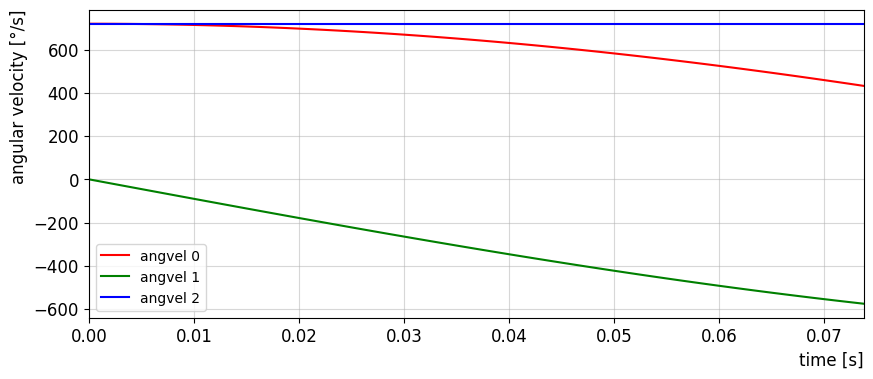

In [2]:
movement = synthetic_signals.single_axis_rotation(9, angular_velocity=(0.05*np.pi, 0, 0), samplerate = 1)
# movement = synthetic_signals.harmonic_vertical_movement(10, samplerate=20, frequency=1)
samplerate = 800
movement = synthetic_signals.coning_motion(60, samplerate = samplerate, theta = np.pi/2, omega=2*np.pi*2)
# synthetic_signals.plot_kinematic_signal(movement)

# Simulate IMU signals.
# g_l = np.array([0, 0, -synthetic_signals.earthgravity_default])
g_l = earthgravity_vector(lat=51.22).T
y_imu = synthetic_signals.imu_signals_from_trajectory(movement)
samplerate_odr = 20
ns = int(samplerate/samplerate_odr)

# Angular velocity plot
synthetic_signals.plot_angular_velocity(movement, fpath='../tex/images/angular_velocity_coning.png')
ns

In [3]:
# Reference variables. Especially q_ref_ls and  v_ref_l will be used as a reference for the IMU signals.
def extract_values_from_movement(movement):
    omega = movement['angvel']
    q_ref_ls = movement['q_ls']
    v_ref_l = movement['vel']
    t = movement['time']
    T = movement['time'][1] - movement['time'][0]
    nt = omega.shape[0]
    return omega, q_ref_ls, v_ref_l, t, T, nt
omega, q_ref_ls, v_ref_l, t, T, nt = extract_values_from_movement(movement)

## Regular case
Using ideal sensors, strapdown integration of each sample, synthetic signal.

In [4]:
def strapdown_integration(y_gyr, y_acc, T, g_l, q_start, v_start):
    # Logs
    q_sdi_ls = np.zeros((nt, 4))
    v_sdi_l = np.zeros((nt, 3))

    # Initial pose according to the reference trajectory.
    q_sdi_ls_i = q_start.copy()
    v_l_i = v_start.copy()

    # Add starting point to log.
    q_sdi_ls[0, :] = q_sdi_ls_i
    v_sdi_l[0, :] = v_l_i

    # Start at one because first sample is for initial pose.
    for i in range(1,nt):
        # Orientation integration.
        dq_i = kinalg.axisangle_to_quaternion(T*y_gyr[i,:])   # q_s(t-1)_s(t)
        q_sdi_ls_i = kinalg.quaternion_multiplication(q_sdi_ls_i, dq_i)

        q_sdi_ls[i,:] = q_sdi_ls_i.copy()   # Add to log.

        # Accelerometer integration
        v_l_i = v_l_i + T*kinalg.vector_rotation(q_sdi_ls[i,:], y_acc[i,:]) + T*g_l
        v_sdi_l[i,:] = v_l_i.copy()

    return q_sdi_ls, v_sdi_l

q_sdi_ls, v_sdi_l = strapdown_integration(y_imu['y_gyr'], y_imu['y_acc'], T, g_l, q_ref_ls[0,:], v_ref_l[0,:])
sdi_helper.save_to_reference_log_simple_strapdown(y_imu, q_sdi_ls, t)


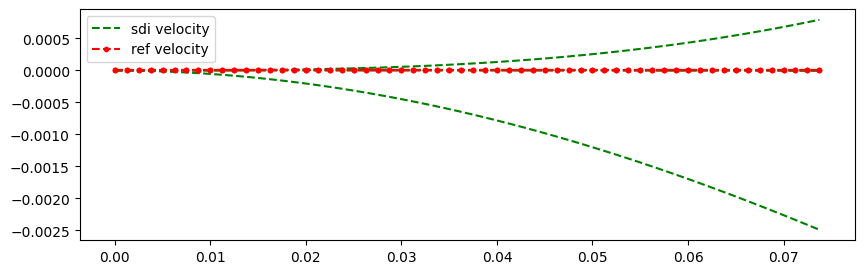

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3), squeeze=False)
axs = axs[:,0]
# axs[0].plot(t, q_ref_ls,  color='red', marker='.', label='Ref');
# axs[0].plot(t, q_sdi_ls,  color='green', marker='.', linestyle='--', label='sdi');
# axs[0].plot(t_odr, q_log,  color='blue', marker='o', linestyle='--', label='ODR');
axs[0].plot(t, v_sdi_l,  color='green', linestyle='--', label='sdi velocity');
axs[0].plot(t, v_ref_l,  color='red', marker='.', linestyle='--', label='ref velocity');

plot_utils.remove_matplotlib_multiple_legend(axs[0])

# Strapdown integration in intervals.
Output of the IMU is ODR [Hz], internal sampling rate is much higher (1/T). Small sections of data are integrated on IMU and concatenated at the host.

In [6]:
def _get_interval_lengths(nt, ns, verbose=True):
    nt_used = nt - 1  # number of samples used in the integration (excluding t0).
    n_intervals = int(np.ceil(nt_used/ns))
    if verbose:
        print(f'Total number of samples used {nt_used}, chopped into {n_intervals} intervals of {ns} samples.')
    return nt_used, n_intervals

def strapdown_integration_on_interval(y_gyr_section, y_acc_section, T):
    """Strapdown integration over an interval D, intented to run on the IMU. Returns a change in orientation 
    and velocity at the end of the interval. The change in velocity includes the gravitational component.

    T is the samplerate with which y_gyr_section and y_acc_section are sampled, tyipcally hundreds of Hz.

    dq is the change in orientation from the start to the end of the interval.
    dv is the change in velocity from the start to the end of the interval, including the gravitational component. It's expressed
    in the last orientation of the interval.
    """
    # change in orientation and velocity resets at beginning of interval.
    dq, dv = np.asarray([1, 0, 0, 0]), np.asarray([0,0,0])
    
    for y_gyr_i, y_acc_i in zip(y_gyr_section, y_acc_section):
        dq = kinalg.quaternion_multiplication(dq, kinalg.axisangle_to_quaternion(T*y_gyr_i))  # dq_s0_si
        dv = dv + T*kinalg.quaternion_to_rotationmatrix(dq)@y_acc_i                           # dv between si and s0, expressed in s0.

    # Per definition, quantities are expressed in the last position of the interval.
    dv = kinalg.quaternion_to_rotationmatrix(dq).T@dv    
    return dq, dv


def strapdown_integration_in_intervals(y_gyr, y_acc, T, g_l, q_start, v_start, ns=3, verbose=False):
    """
    Mechanization on the host: concatenate the IMU output (dq, dv) and correct for the gravitational acceleration.
    ns is the number of samlpes within and ODR interval.
    """
    nt_used, n_intervals = _get_interval_lengths(y_gyr.shape[0], ns, verbose=verbose)

    # Init logs. First element of log is the starting position.
    t_odr = np.zeros(n_intervals+1) # Times in which the orientation and velocity are available to the user.
    q_log = np.zeros((n_intervals+1, 4))
    v_log = np.zeros((n_intervals+1, 3))

    # Starting orientation and velocity.
    q_LS_j, v_j = q_start, v_start # Initial orientation and velocity.
    q_log[0, :] = q_LS_j.copy()
    v_log[0, :] = v_j.copy()

    for j_interval in range(1, n_intervals+1):
        i_start = (j_interval-1)*ns + 1
        i_end = min(nt_used+1, j_interval*ns+1) # i_end is in the python range, so it is not included.
        t_odr[j_interval] = t[i_end-1].copy()

        # This part is computed on the IMU device.
        dq, dv = strapdown_integration_on_interval(y_gyr[i_start:i_end], y_acc[i_start:i_end], T)

        # Concatenate ODR intervals. This is generally done where the data is used in an drift-reducing algorithm.
        q_LS_j = kinalg.quaternion_multiplication(q_LS_j, dq) # Orientation at ODR intervals.
        n_samples_in_interval = i_end - i_start
        v_j = v_j + kinalg.quaternion_to_rotationmatrix(q_LS_j)@dv  + n_samples_in_interval*T*g_l      # Velocity at ODR intervals, in L coordinates

        # Store in log
        q_log[j_interval, :] = q_LS_j.copy()
        v_log[j_interval, :] = v_j.copy()
    return q_log, v_log, t_odr

# Run on our example data.
q_log, v_log, t_odr = strapdown_integration_in_intervals(y_imu['y_gyr'], y_imu['y_acc'], T, g_l, q_ref_ls[0,:], v_ref_l[0,:], ns=ns)

In [7]:
def strapdown_integration_in_averaged_intervals(y_gyr, y_acc, T, g_l, q_start, v_start, ns=3, verbose=False):
    """
    Modification of strapdown_integration_in_intervals. The on-imu integration is just an average, to simulate a low-pass anti-aliasing filter. This 
    does not account for non commutativity.
    ns is the number of samlpes within and ODR interval.
    """
    nt_used, n_intervals = _get_interval_lengths(y_gyr.shape[0], ns, verbose=verbose)

    # Init logs. First element of log is the starting position.
    t_odr = np.zeros(n_intervals+1) # Times in which the orientation and velocity are available to the user.
    q_log = np.zeros((n_intervals+1, 4))
    v_log = np.zeros((n_intervals+1, 3))

    # Starting orientation and velocity.
    q_LS_j, v_j = q_start, v_start # Initial orientation and velocity.
    q_log[0, :] = q_LS_j.copy()
    v_log[0, :] = v_j.copy()

    for j_interval in range(1, n_intervals+1):
        i_start = (j_interval-1)*ns + 1
        i_end = min(nt_used+1, j_interval*ns+1) # i_end is in the python range, so it is not included.
        t_odr[j_interval] = t[i_end-1].copy()

        # This part is computed on the IMU device.
        # dq, dv = strapdown_integration_on_interval(y_gyr[i_start:i_end], y_acc[i_start:i_end], T)
        n_samples_in_interval = i_end - i_start
        Todr = n_samples_in_interval*T
        dq = kinalg.axisangle_to_quaternion(Todr*y_gyr[i_start:i_end].mean(axis=0))
        dv = Todr*y_acc[i_start:i_end].mean(axis=0)

        # Concatenate ODR intervals. This is generally done where the data is used in an drift-reducing algorithm.
        q_LS_j = kinalg.quaternion_multiplication(q_LS_j, dq) # Orientation at ODR intervals.
        v_j = v_j + kinalg.quaternion_to_rotationmatrix(q_LS_j)@dv  + n_samples_in_interval*T*g_l      # Velocity at ODR intervals, in L coordinates

        # Store in log
        q_log[j_interval, :] = q_LS_j.copy()
        v_log[j_interval, :] = v_j.copy()
    return q_log, v_log, t_odr

q_avg, v_avg, t_avg = strapdown_integration_in_averaged_intervals(y_imu['y_gyr'], y_imu['y_acc'], T, g_l, q_ref_ls[0,:], v_ref_l[0,:], ns=ns)

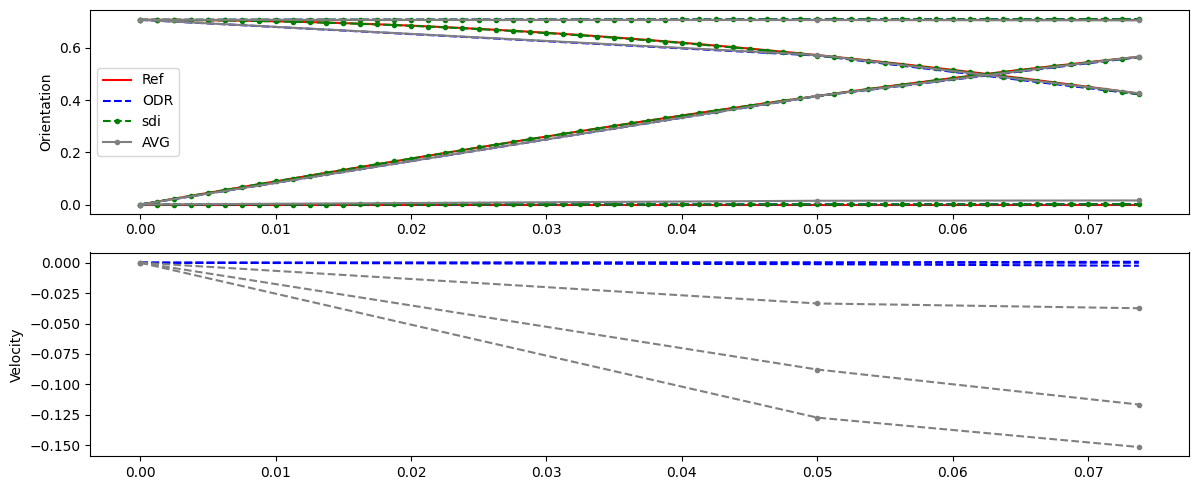

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5), squeeze=False)
axs = axs[:,0]
axs[0].set_ylabel('Orientation')
axs[0].plot(t, q_ref_ls,  color='red', marker='none', label='Ref');
axs[0].plot(t_odr, q_log,  color='blue', marker='none', linestyle='--', label='ODR');
axs[0].plot(t, q_sdi_ls,  color='green', marker='.', linestyle='--', label='sdi');
axs[0].plot(t_avg, q_avg,  color='grey', marker='.', linestyle='-', label='AVG');

axs[1].set_ylabel('Velocity')
# axs[1].plot(t, v_ref_l,  color='red', marker='.', label='Ref');
axs[1].plot(t_odr, v_log,  color='blue', marker='none', linestyle='--', label='ODR');
axs[1].plot(t_avg, v_avg,  color='grey', marker='.', linestyle='--', label='ODR');

# axs[1].plot(t, v_sdi_l,  color='green', marker='.', linestyle='--', label='sdi');

plot_utils.remove_matplotlib_multiple_legend(axs[0])
fig.tight_layout()

### Helper function
to compute orientation errors the reference log is downsampled.

In [9]:
q_ref_ls_odr = sdi_helper.sample_to_odr(q_ref_ls, t, t_odr)

### Integration drift
illustration

40


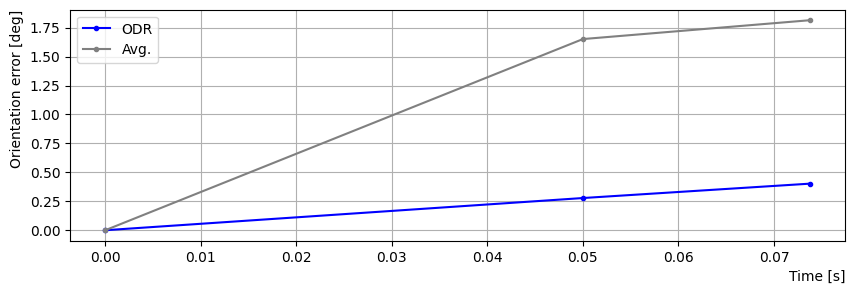

In [11]:
# Orientation errors.
e_odr_err = np.linalg.norm((180/np.pi)*kinalg.array_quaternion_to_axisangle(kinalg.array_quaternion_mult(kinalg.array_quaternion_inverse(q_log), q_ref_ls_odr)), axis=1)
e_avg_err = np.linalg.norm((180/np.pi)*kinalg.array_quaternion_to_axisangle(kinalg.array_quaternion_mult(kinalg.array_quaternion_inverse(q_avg), q_ref_ls_odr)), axis=1)

_, axs = plt.subplots(1, 1, figsize=(10, 3), squeeze=False)
ax = axs[0,0]
ax.plot(t_odr, e_odr_err, color='blue', marker='.', label='ODR');
ax.plot(t_odr, e_avg_err, color='grey', marker='.', label='Avg.');
ax.set_xlabel('Time [s]', loc='right')
ax.set_ylabel('Orientation error [deg]', loc='top')	
ax.grid()
ax.legend()
print(ns)
plt.savefig('../tex/images/typical_integration_drift.png', dpi=300, bbox_inches='tight')


### Integration drift versus ODR.

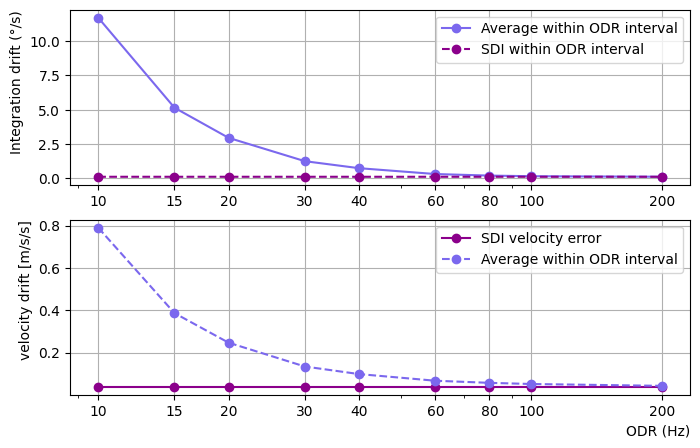

In [16]:
def _get_error(q_ref_ls, q_avg, t, t_avg):
    q_ref_ls_odr = sdi_helper.sample_to_odr(q_ref_ls, t, t_avg)
    q_error_avg = kinalg.array_quaternion_mult(q_ref_ls_odr, kinalg.array_quaternion_inverse(q_avg))
    ei_avg = kinalg.array_quaternion_to_axisangle(q_error_avg)
    ei_avg = np.max(np.linalg.norm(ei_avg, axis=1, ord=2))*180/np.pi # Convert to degrees.
    return ei_avg

duration = 4 # seconds. Should contain several periods of movement, yet not come close to 180 degrees maximum error.
samplerate = 800 # Hz, on IMU.
samplerates_odr = [10, 15, 20, 30, 40, 60,  80, 100, 200] # Hz
# samplerates_odr = [10, 15, 100, 200] # Hz

# Allocate memory for errors.
e_avg = np.zeros((len(samplerates_odr), 2))  # To store the errors
e_odr = np.zeros((len(samplerates_odr), 2))  # To store the errors

# Create coning movement
n_samples = duration * samplerate
movement = synthetic_signals.coning_motion(n_samples, samplerate, theta = np.pi/2, omega=1*np.pi*2)
omega, q_ref_ls, v_ref_l, t, T, nt = extract_values_from_movement(movement)

# Process for different ODR frequencies.
for i, samplerate_odr in enumerate(samplerates_odr):

    y_imu = synthetic_signals.imu_signals_from_trajectory(movement)
    ns = int(samplerate/samplerate_odr)
    q_avg, v_avg, t_avg = strapdown_integration_in_averaged_intervals(y_imu['y_gyr'], y_imu['y_acc'], T, g_l, q_ref_ls[0,:], v_ref_l[0,:], ns=ns)
    q_odr, v_odr, t_odr = strapdown_integration_in_intervals(y_imu['y_gyr'], y_imu['y_acc'], T, g_l, q_ref_ls[0,:], v_ref_l[0,:], ns=ns)

    # Error per second.
    e_avg[i, 0] = _get_error(q_ref_ls, q_avg, t, t_avg)/duration
    e_odr[i, 0] = _get_error(q_ref_ls, q_odr, t, t_odr)/duration

    e_avg[i, 1] = np.max(np.linalg.norm(v_avg -  sdi_helper.sample_to_odr(v_ref_l, t, t_avg), axis=1))/duration
    e_odr[i, 1] = np.max(np.linalg.norm(v_odr -  sdi_helper.sample_to_odr(v_ref_l, t, t_avg), axis=1))/duration

# Plot errors versus ODR frequency.
_, axs = plt.subplots(2, 1, figsize=(8, 5), squeeze=False)
ax = axs[0,0]
ax.plot(samplerates_odr, e_avg[:, 0], color='mediumslateblue', marker='o', label='Average within ODR interval')
ax.plot(samplerates_odr, e_odr[:, 0], color='darkmagenta', marker='o', linestyle='--', label='SDI within ODR interval')
# ax.set_ylim(0, 1.2*e_avg.max())
ax.set_ylabel('Integration drift (°/s)', loc='top')
ax.grid()
ax.set_xscale('log')
# ax.set_yscale('log')

ax.legend()
ax.set_xticks(samplerates_odr)
ax.get_xaxis().set_major_formatter(ScalarFormatter())

ax = axs[1,0]
ax.plot(samplerates_odr, e_odr[:,1], color='darkmagenta', marker='o', linestyle='-', label='SDI velocity error')
ax.plot(samplerates_odr, e_avg[:,1], color='mediumslateblue', marker='o', linestyle='--', label='Average within ODR interval')

ax.grid()
ax.set_xscale('log')
# ax.set_yscale('log')

ax.legend()
ax.set_xticks(samplerates_odr)
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.set_xlabel('ODR (Hz)', loc='right')
ax.set_ylabel('velocity drift [m/s/s]', loc='top')

plt.axis('tight')
plt.savefig('../tex/images/drift_versus_odr_frequency.png', dpi=300, bbox_inches='tight')
